# Статистический анализ данных сервиса аренды самокатов GoFast

Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**без подписки**

* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;

**с подпиской Ultra**

* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

Цель исследования:

1. Проверить данные на предмет выбросов и аномалий;
2. Проанализировать м подсчтать выручку от аренды самокатов;
3. Проверить ряд гипотез:
   * Тратят ли пользователи с подпиской больше времени на поездки
   * Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
   * Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Ход исследования:

В нашем распоряжении имеются файлы, содержащие данные о пользователях, поездках и тарифахсервиса. Пути к файлам:
* /datasets/users_go.csv
* /datasets/rides_go.csv
* /datasets/subscriptions_go.csv

Таким образом исследование пройдет в шесть этапов:
* Загрузка данных.
* Предобработка данных.
* Исследовательский анализ данных.
* Объединение данных.
* Подсчёт выручки
* Проверка гипотез.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from random import randint
from scipy import stats as st

## Шаг 1. Загрузка данных

##### Считайте CSV-файлы

In [2]:
try:
    users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
except:
    users_go = pd.read_csv('/datasets/users_go.csv') 

users_go.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [3]:
try:
    rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
except:
    rides_go = pd.read_csv('/datasets/rides_go.csv')

rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [4]:
try:
    subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
except:
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


##### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

**Изучим датасет users_go**

In [5]:
users_go.info()
#users_go.duplicated().sum()
#sorted(users_go['age'].unique(), reverse=True)
#sorted(users_go['city'].unique(), reverse=True)
#sorted(users_go['subscription_type'].unique(), reverse=True)
#users_go.hist(figsize=(20, 10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Итого: пропусков нет, 31 явный дубликат, вид уникальных значений типа не вызывает подозрений

**Изучим датасет rides_go**

In [6]:
rides_go.info()
#rides_go.duplicated().sum()
#sorted(rides_go['distance'].unique(), reverse=True)
#sorted(rides_go['duration'].unique(), reverse=True)
#sorted(rides_go['date'].unique(), reverse=True)
#rides_go.hist(figsize=(20, 10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Итого: нет пропусков, нет явных дубликатов, вид уникальных значений типа не вызывает подозрений.  Столбцы distance и duration можно округлить. Столбец date требуется поменять на временной формат.

**Изучим датасет subscriptions_go**

In [7]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Итого: ок

**Вывод:**

Были изучены имеющиеся датасеты. Явных выбросов и некорректных значений не набдюдается.
* В users_go необходимо удалить явные дубликаты;
* В rides_go требуется округлить столбцы distance и duration. Столбец date требуется поменять на временной формат.

<div class="alert alert-block alert-success">✔️
    
__Комментарий от ревьюера №1__
    
Отлично! Первый взгляд на данные есть

## Шаг 2. Предобработка данных

##### Приведите столбец date к типу даты pandas.

In [8]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')
#rides_go.info() #проверили

##### Создайте новый столбец с номером месяца на основе столбца date

In [9]:
rides_go['month'] = rides_go['date'].dt.month
#rides_go.head() #проверили

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Хорошо бы проверить за какой период у нас данные. Проверить столбец длительности на предмет наличия аномалий. Например, если у нас разные года то январь 2021 и январь 2022 будут под одной цифрой (1). 
</div>

<div class="alert alert-info"> <b>Комментарии студента:</b> Сделано. Ниже отсортировал все уникальные згначения по столбцу date. Видим, что данные только за 2021 год. Получение 2 одинаковых месяцев разного года под одной цифрой исключено.</div>

In [10]:
rides_go['date'].dt.year.sort_values().unique()

array([2021], dtype=int64)

##### Проверьте наличие пропущенных значений и дубликатов в датафреймах

In [11]:
#Удаляем дубликаты в users_go
users_go = users_go.drop_duplicates()
#users_go.duplicated().sum() #проверили

In [12]:
#округляем rides_go['distance'] до 1 значения после запятой
rides_go['distance'] = rides_go['distance'].round(1)
#rides_go['distance'].head() #проверили

In [13]:
#округляем rides_go['duration'] по подсказке в описании проекта через np.ceil
rides_go['duration'] = np.ceil(rides_go['duration'])
#rides_go['duration'].head()
#т.к. np.ceil округляет до целых, можем поменять тип данных на int
rides_go['duration'] = rides_go['duration'].astype(int)
#rides_go.info()

**Вывод**

В процессе предобработки данных было проделаны следующие действия:
* поменяли столбец rides_go['date'] на временной формат;
* cоздали новый столбец rides_go['month'] с номером месяца на основе столбца date;
* округлили столбец rides_go['distance'] до 1 значения после запятой;
* округлили столбец rides_go['duration'] по подсказке в описании проекта через np.ceil поменяли тип данных на int. 


<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Отлично, что используешь именно np.ceil(). Грамотный шаг

## Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [14]:
#составим сводную таблицу с индексом столбца city и функцией count от любого столбца, например name.
city_pivot = users_go.pivot_table(index='city', values='name', aggfunc='count')
#заменим название столбца count
city_pivot.columns = ['количество юзеров']
#отсортируем по убыванию
city_pivot = city_pivot.sort_values(by='количество юзеров', ascending=False)
city_pivot

,количество юзеров
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


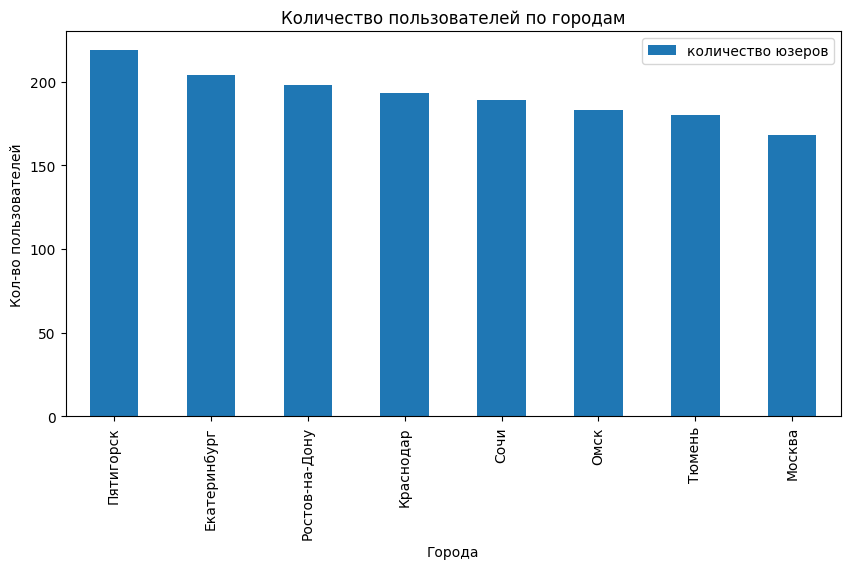

In [15]:
#построим столбчатую диаграмму
city_pivot.plot(kind='bar', figsize=(10,5), title='Количество пользователей по городам', xlabel='Города', ylabel='Кол-во пользователей');

Наиболее часто встречающийся город это Пятигорск. Наименее встречающийся - Москва

##### Соотношение пользователей с подпиской и без подписки

In [16]:
#составим сводную таблицу с индексом столбца subscription_type и функцией count от любого столбца, например name.
subscribe_pivot = users_go.pivot_table(index='subscription_type', values='name', aggfunc='count')
subscribe_pivot.columns = ['количество юзеров']
#добавим столбец доли юзеров в процентном соотношении и округлим до 2 значений после запятой
subscribe_pivot['процент'] = (subscribe_pivot['количество юзеров']/subscribe_pivot['количество юзеров'].sum()).round(2)
subscribe_pivot

,количество юзеров,процент
subscription_type,,
free,835,0.54
ultra,699,0.46


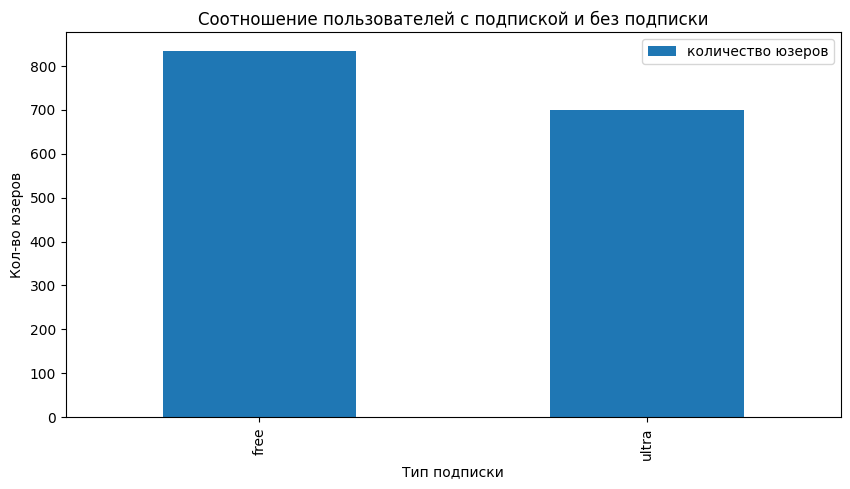

In [17]:
#построим столбчатую диаграмму
subscribe_pivot.plot(kind='bar',y='количество юзеров', figsize=(10,5), title='Соотношение пользователей с подпиской и без подписки', xlabel='Тип подписки', ylabel='Кол-во юзеров');

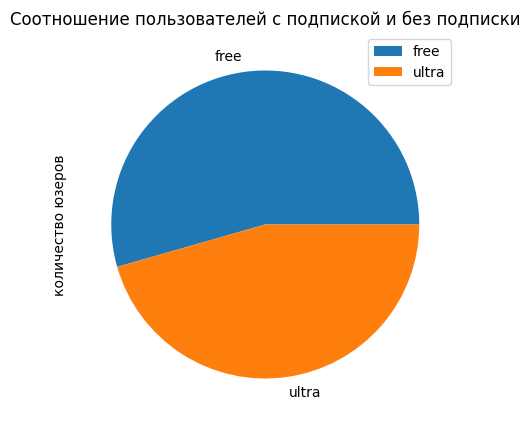

In [18]:
# т.к. категорий всего 2, данные можно отобразить и в виде круговой диаграммы
subscribe_pivot.plot(kind='pie', y='количество юзеров', figsize=(10,5), title='Соотношение пользователей с подпиской и без подписки');

Пользателей с подпиской на 8% больше, чем без подписки

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Пользователей с подпиской немного меньше, тем не менее у компании-прокатчика есть неплохая база постоянных клиентов.

##### Возраст пользователей

In [19]:
#посмотрим среднее методом describe
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [20]:
#Посмотрим количество юзеров по возрасту через value_counts
users_go['age'].value_counts()
#len(users_go['age'].unique()) #посмотрел сколько уникальных значений

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

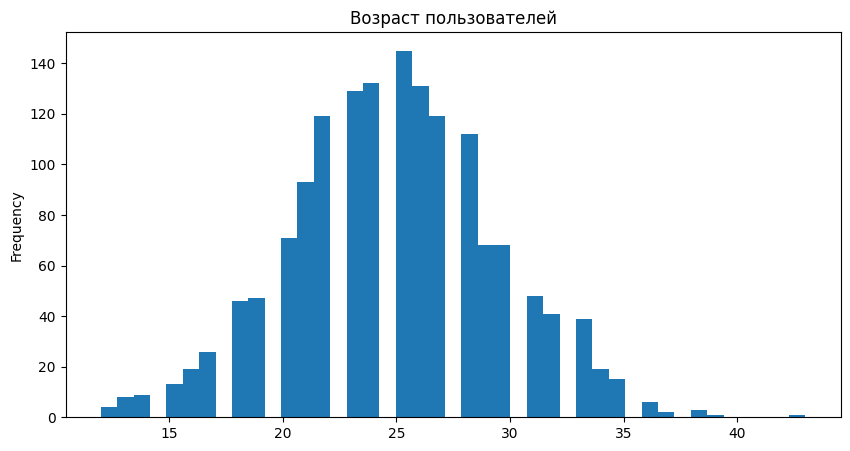

In [21]:
#визуализируем через гистограмму
users_go['age'].plot(kind='hist', bins=43, figsize=(10,5), title='Возраст пользователей', xlabel='Возраст', ylabel='Кол-во юзеров');

По гистограмме видно, что самое большое число пользователей находится в промежутке от 20 до 30 лет. Средний возраст пользователей - 25 лет.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Основная часть пользователей возрастом от 22 до 28 лет. Все что меньше 15 лет и больше 40 можно считать редкими значениями.

##### Расстояние, которое пользователь преодолел за одну поездку

In [22]:
#Исследуем rides_go['distance'] через describe и гистограмму
rides_go['distance'].describe()

count    18068.000000
mean      3070.659841
std       1116.831106
min          0.900000
25%       2543.200000
50%       3133.600000
75%       3776.225000
max       7211.000000
Name: distance, dtype: float64

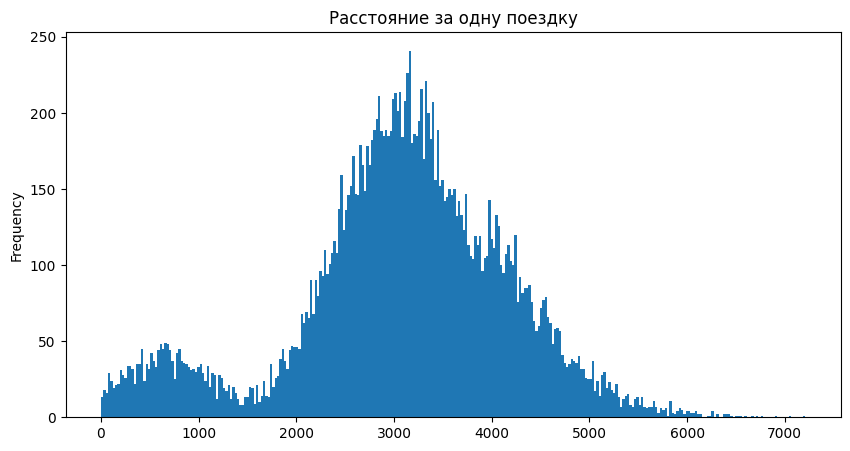

In [23]:
rides_go['distance'].plot(kind='hist', bins=300, figsize=(10,5), title='Расстояние за одну поездку', xlabel='Расстояние', ylabel='Кол-во юзеров');

По гистограмме видно, что самое большое число поездок с расстоянием в промежутке от 2500 до 3500 метров. Средне расстояние за одну поездку 3070 метров. Также выднеется отдельное распределение на отрезке 0-1500 метров. Посмотрим на него отдельно.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Основная часть поездок занимает от 2500 до 3800 метров. Медиана 3133 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.

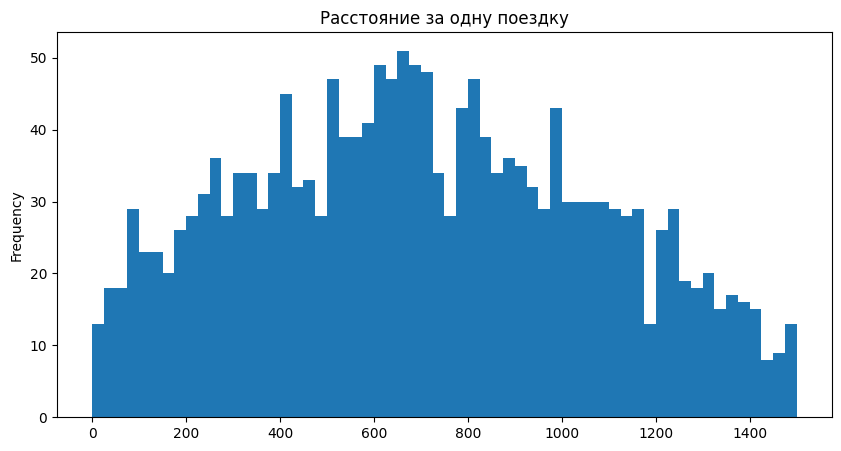

In [24]:
rides_go['distance'].plot(kind='hist', bins=60, range=(0,1500), figsize=(10,5), title='Расстояние за одну поездку', xlabel='Расстояние', ylabel='Кол-во юзеров');

Таким образом есть отдельная категория пользователей на короткие дистанции до 1500 метров. Среди них наиболее частое значение расстояния - примерно 650 метров

##### Продолжительность поездок

In [25]:
#Исследуем rides_go['duration'] через describe и гистограмму
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

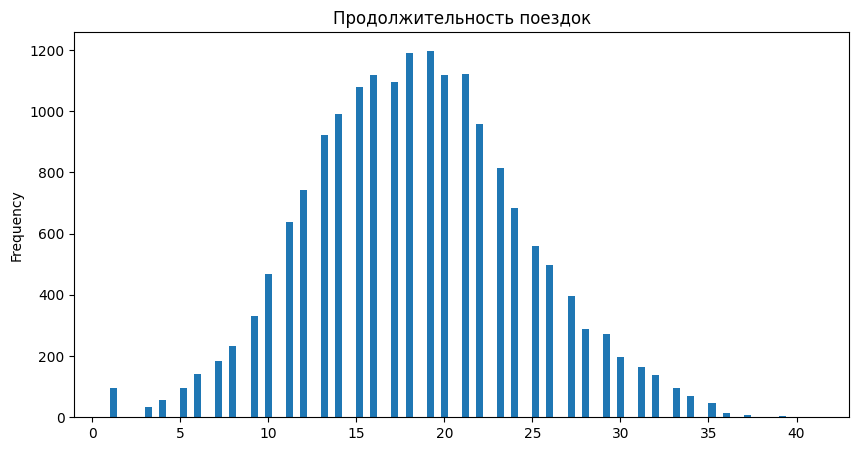

In [26]:
rides_go['duration'].plot(kind='hist', bins=100, figsize=(10,5), title='Продолжительность поездок', xlabel='Время поездки', ylabel='Кол-во юзеров');

Из гистограммы видно что наибольшее количество поездок с продолжительностью от 15 до 21 минуты. Средняя продолжительность равна 18 минутам. 
Также у примерно 100 пользователь видна активность минутных поездок. Данный момент стоит взять во внимание и сообщить менеджменту для изучения.

**Вывод**

Был проведен анализ основных показателей выгрузки, на основании чего были сделаны следующие выводы:
* Наиболее часто встречающийся город это Пятигорск. Наименее встречающийся - Москва;
* Пользателей с подпиской на 8% больше, чем без подписки;
* Самое большое число пользователей находится в промежутке от 20 до 30 лет. Средний возраст пользователей - 25 лет;
* Cамое большое число поездок с расстоянием в промежутке от 2500 до 3500 метров. Средне расстояние за одну поездку 3070 метров. Есть отдельная категория пользователей на короткие дистанции до 1500 метров. Среди них наиболее частое значение расстояния - примерно 650 метров;
* Наибольшее количество поездок с продолжительностью от 15 до 21 минуты. Средняя продолжительность равна 18 минутам. Также привлекли внимание странные поездки длительностью в 1 минуту, требующие отдельного изучения.
По итогам вывода можно описать портрет среднего пользователя - это пользователь с подпиской в возрасте 25 лет, проезжающий 3 км за одну поездку, либо катается 18 мин.

## Шаг 4. Объединение данных

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

 Отсутствует проверка размерности:
    
* размеры датасетов до объединения
* размер результирующего датафрейма (с учетом типа объединения)

<div class="alert alert-info"> <b>Комментарии студента:</b> Сделано. После объединения также посчитал и оставил комментарий</div>

In [27]:
len(rides_go)

18068

In [28]:
len(users_go)

1534

In [29]:
len(subscriptions_go)

2

##### Объединяем данные о пользователях, поездках и подписках в один датафрейм

In [30]:
## Объединим данные в два этапа. Сначала rides_go с users_go по столбцу user_id
rides_users = rides_go.merge(users_go, on='user_id')
#rides_users.head(20) #проверил
rides_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  int32         
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), object(3)
memory usage: 1.3+ MB


In [31]:
#теперь объединим rides_users с subscriptions_go по столбцу subscription_type
rides_users_sub = rides_users.merge(subscriptions_go, on='subscription_type')
rides_users_sub.head()
#rides_users_sub.info() #проверил

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.9,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.6,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.2,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.8,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.7,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [32]:
len(rides_users_sub)

18068

<div class="alert alert-info"> <b>Комментарии студента:</b> Так как соединяли методом merge под столбцу rides_go['user_id'], то количество строк rides_go должен совпадать с новым датафреймом rides_users_sub. Что и получили. Количество строк 18068 совпадают</div>

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №2__

Отлично. Проверка размерности датасетов проведена

##### Создаем ещё два датафрейма: c данными о пользователях без подписки и без

In [33]:
#с подпиской
with_sub = rides_users_sub.query('subscription_type == "ultra"')
with_sub.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.9,26,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.6,16,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.2,7,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.8,19,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.7,27,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [34]:
#без подписки
no_sub = rides_users_sub.query('subscription_type == "free"')
no_sub.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.7,15,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.9,17,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.4,21,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.9,10,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.4,18,2021-02-14,2,Айдар,22,Омск,free,8,50,0


<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Целесообразно вывести несколько строк из общего и отдельных датафреймов.

<div class="alert alert-info"> <b>Комментарии студента:</b> Сделано</div>

##### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

In [35]:
#для with_sub
with_sub.describe()

,user_id,distance,duration,month,age,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,3115.444985,19.037692,6.422308,24.892615,6.0,0.0,199.0
std,201.099339,836.895127,5.577439,3.414616,4.757208,0.0,0.0,0.0
min,1.000000,244.200000,4.000000,1.000000,12.000000,6.0,0.0,199.0
25%,175.000000,2785.400000,15.000000,4.000000,22.000000,6.0,0.0,199.0
50%,351.000000,3148.600000,19.000000,6.000000,25.000000,6.0,0.0,199.0
75%,525.000000,3560.600000,22.000000,9.000000,28.000000,6.0,0.0,199.0
max,699.000000,5699.800000,41.000000,12.000000,38.000000,6.0,0.0,199.0


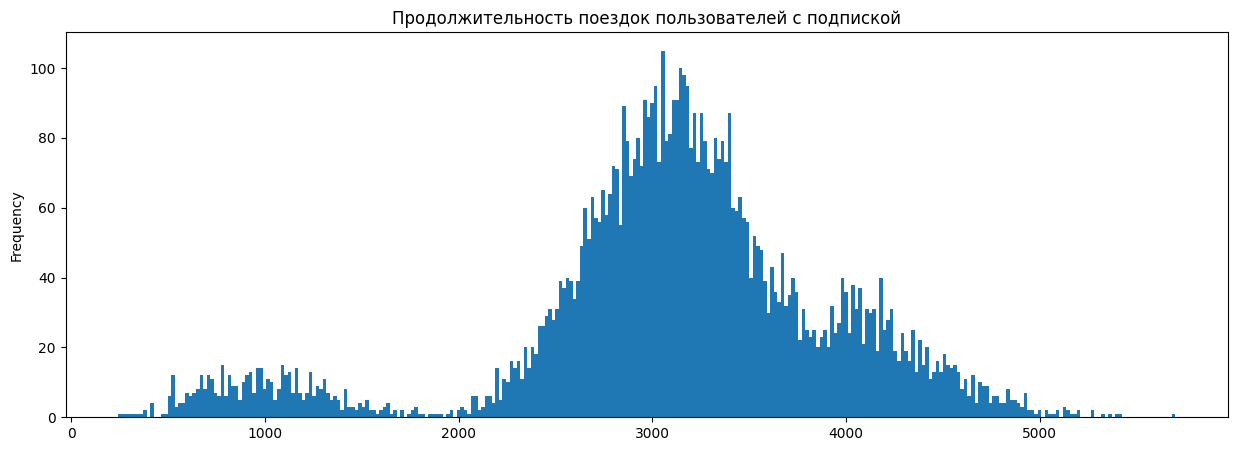

In [36]:
with_sub['distance'].plot(kind='hist', bins=300, figsize=(15, 5), title='Продолжительность поездок пользователей с подпиской', xlabel='Продолжительность поездки', ylabel='Кол-во юзеров');

Пользователей с подпиской проезжает в среднем 3115 метров за одну поездку.

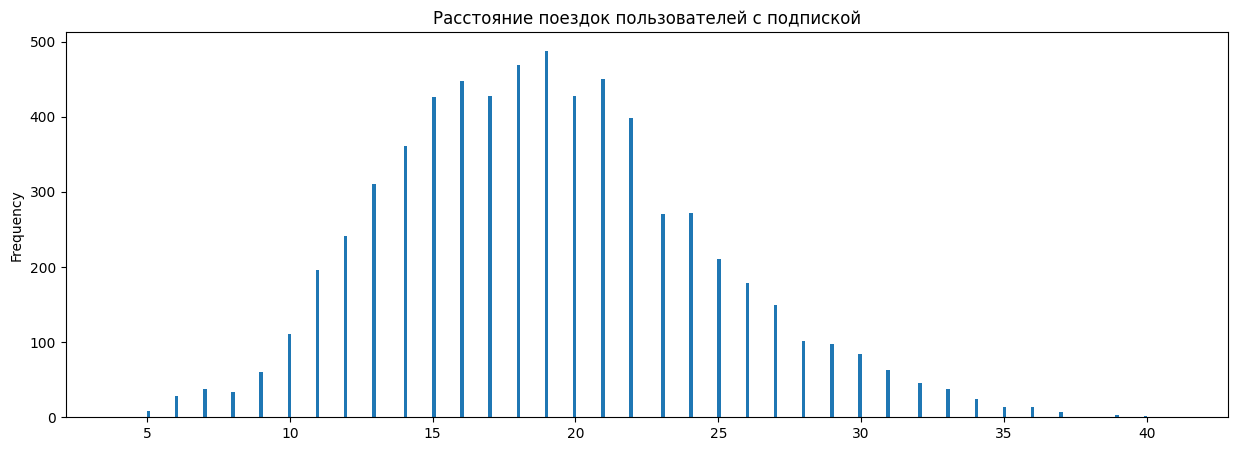

In [37]:
with_sub['duration'].plot(kind='hist', bins=300, figsize=(15, 5), title='Расстояние поездок пользователей с подпиской', xlabel='Расстояние поездки', ylabel='Кол-во юзеров');

Для пользователей с подпиской характерны поездки с длительностью от 15 до 21 минуты. Средняя поездка составлет 19 минут

In [38]:
#для no_sub
no_sub.describe()

,user_id,distance,duration,month,age,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,3045.495297,17.890992,6.522994,24.893326,8.0,50.0,0.0
std,241.165628,1246.173747,6.330250,3.449770,4.481100,0.0,0.0,0.0
min,700.000000,0.900000,1.000000,1.000000,12.000000,8.0,50.0,0.0
25%,915.000000,2366.600000,13.000000,4.000000,22.000000,8.0,50.0,0.0
50%,1123.000000,3114.650000,18.000000,7.000000,25.000000,8.0,50.0,0.0
75%,1328.000000,3905.700000,22.000000,9.000000,28.000000,8.0,50.0,0.0
max,1534.000000,7211.000000,35.000000,12.000000,43.000000,8.0,50.0,0.0


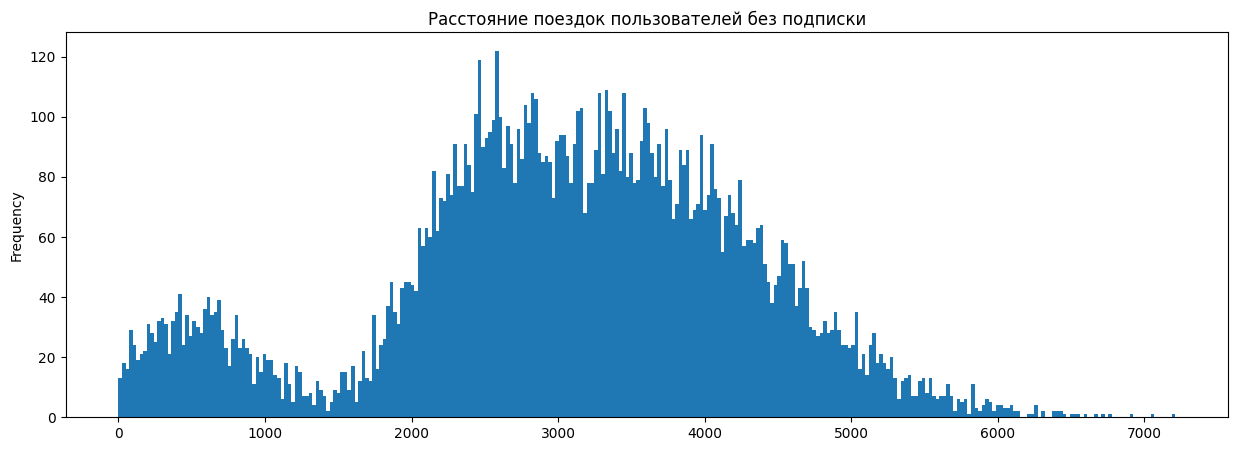

In [39]:
no_sub['distance'].plot(kind='hist', bins=300, figsize=(15, 5), title='Расстояние поездок пользователей без подписки', xlabel='Расстояние поездки', ylabel='Кол-во юзеров');

Для пользователей без подписки средним расстоянием поездки является 3045 метров. Также заметны аномально короткие поездки до 300 метров, на что стоит обратить внимание коллегам. Визуализируем их ниже.

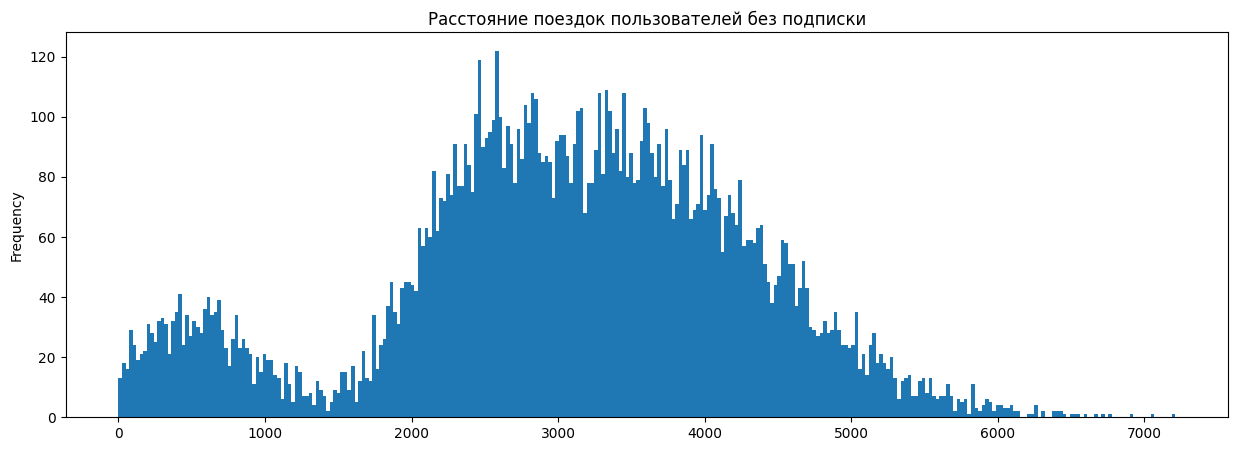

In [40]:
no_sub['distance'].plot(kind='hist', bins=300, figsize=(15, 5), title='Расстояние поездок пользователей без подписки', xlabel='Расстояние поездки', ylabel='Кол-во юзеров');

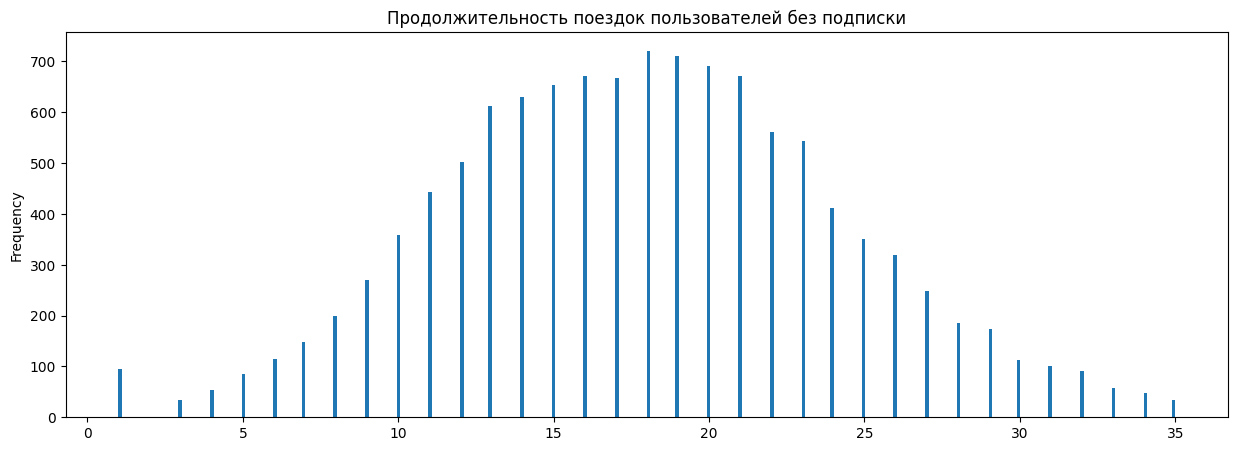

In [41]:
no_sub['duration'].plot(kind='hist', bins=300, figsize=(15, 5), title='Продолжительность поездок пользователей без подписки', xlabel='Продолжительность поездки', ylabel='Кол-во юзеров');

Средняя длительность поездки пользователя без подписки - 18 минут. Также видны ранее замеченные одноминутные поездки у ста пользователей, на которые обратили внимание в предыдущем разделе. Оказалось они относятся к категории пользователей без подписок, что даст больше информации коллегам для изучения данной аномалии.

**Вывод**

Было произведено объединение данных о пользователях, поездках и подписках в один датафрейм. Также создано ещё два датафрейма: c данными о пользователях без подписки и без.
По итогам изучения полученных данных были получены следующие наблюдения:
* Среднее расстояние поездки у пользователей с подпиской 3115 метров против 3045 метров у пользователей без подписки;
* Средняя длителльность поездки у пользователей с подпиской 19 минут против 18 минут у пользователей без подписки;
* Были замечены аномальные поездки на малые расстояния до 200 метров у пользователей с подпиской;
* Были идентифицированы ранее замеченные аномалии коротких одноминутных поездок. Они произведены пользателями без подписки.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.

## Шаг 5. Подсчёт выручки

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__
    
Нет проверки на пропуски в сводной таблице перед расчетом выручки

<div class="alert alert-info"> <b>Комментарии студента:</b> Сделано</div>

In [42]:
rides_users_sub.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

##### Создаем датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц**

In [43]:
#воспользуемся методом сводных таблиц pivot для rides_users_sub
monthly_pivot = rides_users_sub.pivot_table(index=['month', 'user_id'], values=['distance', 'duration', 'date', 'subscription_type'], aggfunc={'distance':sum, 'duration':sum, 'date':len, 'subscription_type' : min}) 
monthly_pivot

date  distance  duration subscription_type
month user_id                                            
1     1           2    7027.5        42             ultra
      3           1    3061.8        13             ultra
      5           1    3914.6        13             ultra
      7           2    6478.1        28             ultra
      12          1    3577.2        33             ultra
...             ...       ...       ...               ...
12    1525        1    4597.9        34              free
      1526        1    3644.1        23              free
      1528        1    3998.6        11              free
      1532        2    6111.9        42              free
      1534        1    2371.7        16              free

[11331 rows x 4 columns]

In [44]:
#переименуем первый столбец в количество поездок
monthly_pivot.columns = ['rides_qty', 'distance', 'duration', 'subscription_type']
#monthly_pivot #проверил

##### В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь**

In [45]:
#сначала создадим функцию для взятия данных с датафрейма subscriptions_go и рассчета прибыли по формуле:(стоимость старта поездки * количество поездок) + (стоимость одной минуты поездки * общая продолжительность всех поездок в минутах) + стоимость подписки
def profit_calc(row):
    try:
        if row['subscription_type'] == 'free':
            cost = subscriptions_go.loc[0]
        else:
            cost = subscriptions_go.loc[1]
        
        profit = cost['start_ride_price'] * row['rides_qty'] + row['duration'] * cost['minute_price'] + cost['subscription_fee']
        return profit
    except:
        pass

monthly_pivot['profit'] = monthly_pivot.apply(profit_calc, axis=1)
monthly_pivot.head()

rides_qty  distance  duration subscription_type  profit
month user_id                                                         
1     1                2    7027.5        42             ultra     451
      3                1    3061.8        13             ultra     277
      5                1    3914.6        13             ultra     277
      7                2    6478.1        28             ultra     367
      12               1    3577.2        33             ultra     397

In [46]:
#Выведем итоговую прибыль за весь период
monthly_pivot['profit'].sum()

3878641

**Вывод**

В данной части был сформирована сводная таблица с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц. Также была подсчитана помесячная выручка, которую принёс каждый пользователь. Прибыль за весь период исследования составила 3878641 руб.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Молодец, что используешь собственные функции

## Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки

Определим нулевую и альтернативную гипотезы:
* H0 - средние значения продолжительности поездки пользователей с подпиской и без подписки равны
* H1 - среднее значение продолжительности поездки пользователей с подпиской больше в сравнении с пользователями без подписки.

Используем двухбырочный t-тест для независимых выборок с уровнем статистической значимости 5%

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Верная интерпретация нулевой и альтернативной гипотез
</div>

In [47]:
alpha = 0.05
print('Среднее значение продолжительности поездки пользователей с подпиской:', with_sub['duration'].mean())
print('Среднее значение продолжительности поездки пользователей без подписки:', no_sub['duration'].mean())
results = st.ttest_ind(with_sub['duration'], no_sub['duration'], alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Среднее значение продолжительности поездки пользователей с подпиской: 19.037692307692307
Среднее значение продолжительности поездки пользователей без подписки: 17.890992392807746
p-значение: 2.495945372073663e-34
Отвергаем нулевую гипотезу


На основании теста нулевая гипотеза была отвергнута, значит есть возможность полагать, что пользователи с подпиской тратят больше времени на поездки, тем самым быть более выгодными для компании.

##### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

* H0 - среднее расстояние поездки пользователей с подпиской равно 3130 метров
* H1 - среднее расстояние поездки пользователей с подпиской больше 3130 метров

Используем одновыборочный t-тест с уровнем статистической значимости 5%

In [48]:
limit = 3130
alpha = 0.05
results = st.ttest_1samp(with_sub['distance'], limit, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.9195427368335853
Не отвергаем нулевую гипотезу


На основании теста нулевая гипотеза не может быть отвергнута, значит есть возможность полагать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

##### Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

* H0 - средняя помесячная выручка от пользователей с подпиской равна средней помесячной выручке от пользователей без подписки
* H1 - средняя помесячная выручка от пользователей с подпиской превышает среднюю помесячную выручку от пользователей без подписки

Используем двухвыборочный t-тест для независимых выборок с уровнем статистической значимости 5%

In [49]:
#для начала подготовим 2 среза из сводной таблицы monthly_pivot методом query
with_sub_profit = monthly_pivot.query('subscription_type == "ultra"')['profit']
no_sub_profit = monthly_pivot.query('subscription_type == "free"')['profit']

In [50]:
alpha = 0.05
print('Средняя помесячная выручка от пользователей с подпиской:', with_sub_profit.mean())
print('Средняя помесячная выручка от пользователей без подписки:', no_sub_profit.mean())
results = st.ttest_ind(with_sub_profit, no_sub_profit, alternative='greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Средняя помесячная выручка от пользователей с подпиской: 362.7921906022502
Средняя помесячная выручка от пользователей без подписки: 328.6413651073845
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


На основании теста нулевая гипотеза может быть отвергнута, значит есть возможность полагать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Методологически проверка гипотез проведена верно и наглядный вывод результатов

##### Какой тест вам понадобился бы для проверки этой гипотезы, что из-за обновления сервера количество обращений в техподдержку значимо снизилось

У нас имеется некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Эти данные можно представить как две зависимые выборки. В этом случае нам идеально подойдет двухвыборочный тест для зависимых выборок - st.ttest_rel(before, after)

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Для решения потребуется тест на равенство средних для зависимых выборок, до и после изменений.>

**Вывод**

Был проверен ряд гипотез. Ниже представлены результаты проверок:
1. Нулевая гипотеза была отвергнута, значит есть возможность полагать, что пользователи с подпиской тратят больше времени на поездки, тем самым быть более выгодными для компании;
2. Нулевая гипотеза не может быть отвергнута, значит есть возможность полагать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
3. Нулевая гипотеза может быть отвергнута, значит есть возможность полагать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Для проверки количества обращений до обновления сервера и после него идеально подойдет двухвыборочный тест для зависимых выборок - st.ttest_rel(before, after).

## Общий вывод

В ходе проведения исследования были проделаны следующие этапы:

1. **Загрузка данных**

Были изучены имеющиеся датасеты. Обнаружили явные дубликаты, некорректный формат столбца date и числовые значения, требующие округления.

2. **Предобработка данных**

В процессе предобработки данных было проделаны следующие действия:

* поменяли столбец rides_go['date'] на временной формат;
* cоздали новый столбец rides_go['month'] с номером месяца на основе столбца date;
* округлили столбец rides_go['distance'] до 1 значения после запятой;
* округлили столбец rides_go['duration'] по подсказке в описании проекта через np.ceil поменяли тип данных на int.

3. **Исследовательский анализ данных**

Был проведен анализ основных показателей выгрузки, на основании чего были сделаны следующие выводы:

* Наиболее часто встречающийся город это Пятигорск. Наименее встречающийся - Москва;
* Пользателей с подпиской на 8% больше, чем без подписки;
* Самое большое число пользователей находится в промежутке от 20 до 30 лет. Средний возраст пользователей - 25 лет;
* Cамое большое число поездок с расстоянием в промежутке от 2500 до 3500 метров. Средне расстояние за одну поездку 3070 метров. Есть отдельная категория пользователей на короткие дистанции до 1500 метров. Среди них наиболее частое значение расстояния - примерно 650 метров;
* Наибольшее количество поездок с продолжительностью от 15 до 21 минуты. Средняя продолжительность равна 18 минутам. Также привлекли внимание странные поездки длительностью в 1 минуту, требующие отдельного изучения. По итогам вывода можно описать портрет среднего пользователя - это пользователь с подпиской в возрасте 25 лет, проезжающий 3 км за одну поездку, либо катается 18 мин

4. **Объединение даннных**

Было произведено объединение данных о пользователях, поездках и подписках в один датафрейм. Также создано ещё два датафрейма: c данными о пользователях без подписки и без. По итогам изучения полученных данных были получены следующие наблюдения:

* Среднее расстояние поездки у пользователей с подпиской 3115 метров против 3045 метров у пользователей без подписки;
* Средняя длителльность поездки у пользователей с подпиской 19 минут против 18 минут у пользователей без подписки;
* Были замечены аномальные поездки на малые расстояния до 200 метров у пользователей с подпиской;
* Были идентифицированы ранее замеченные аномалии коротких одноминутных поездок. Они произведены пользателями без подписки.

5. **Подсчет выручки**

В данной части был сформирована сводная таблица с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц. Также была подсчитана помесячная выручка, которую принёс каждый пользователь. Прибыль за весь период исследования составила 3878641 руб.

6. **Проверка гипотез**

Был проверен ряд гипотез. Ниже представлены результаты проверок:

* Нулевая гипотеза была отвергнута, значит есть возможность полагать, что пользователи с подпиской тратят больше времени на поездки, тем самым быть более выгодными для компании;
* Нулевая гипотеза не может быть отвергнута, значит есть возможность полагать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
* Нулевая гипотеза может быть отвергнута, значит есть возможность полагать, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
* Для проверки количества обращений до обновления сервера и после него идеально подойдет двухвыборочный тест для зависимых выборок - st.ttest_rel(before, after).

Подводя итог, могу посоветовать менеджменту сервиса взять курс на увеличение числа пользователей с подпиской, т.к. они приносят больший доход. Также команде по эксплуатации следует обратить внимание и изучить природу аномально коротких поездок, длительностью в 1 минуту.    

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Итоговый вывод завершает твое исследование. Представлены основные результаты полученные в ходе анализа, но не увидел каких либо рекомендаций по развитию аренды самокатов в разрезе твоего исследования. Добавь, пожалуйста



<div class="alert alert-info"> <b>Комментарии студента:</b> Сделано последним абзацем в выводе. Спасибо за замечания и проверку🙂</div>

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №2__

Это тебе спасибо за обратную связь и крутой проект ^^

## Распределения

### Задача 1

In [51]:
from scipy.stats import binom, norm
from math import sqrt

115.60445163626672

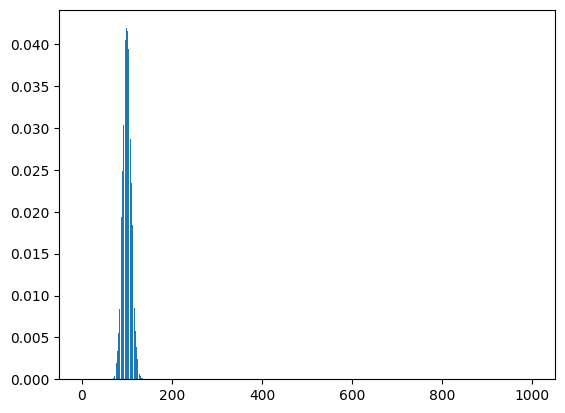

In [52]:
# задаём параметры биномиального распределения. Т.к 100 человек это 10%, значит n = 1000
n = 1000
p = 0.1
# строим график
distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1-p)**(n-k) 
    distr.append(prob)
    
plt.bar(range(0, n+1), distr)

mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma) 
# 5% невыполнения плана это 95% выполнения плана
result = distr.ppf(0.95)
result

Т.е 115,6*10 = 1156 промокодов должно быть разослано, чтобы 100 пользователей купили подписку при вероятности не выполнить план в 5%

### Задача 2

0.15371708296369768


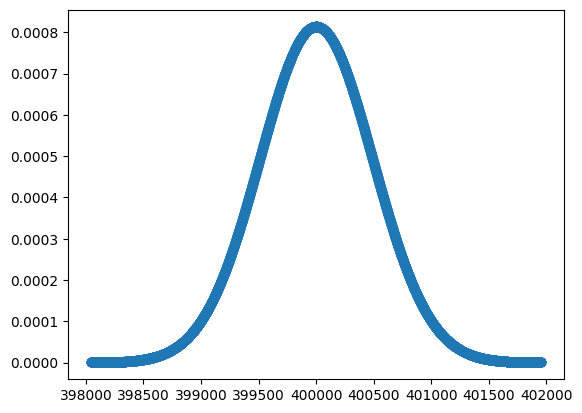

In [53]:
n = 1000000
p = 0.4
# строим график (взял пример из урока)
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
x = list(range(max(0, left), right))
ax = plt.subplot()

ax.plot(x, binom.pmf(x, n, p), 'o')
# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 


result = distr.cdf(399500)
print(result)

Примерно 15.3% составляет вероятность, что при рассылке 1000000 уведомлений их откроют не более 399500 человек.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Всё правильно

<div class="alert alert-block alert-warning">📝
Комментарий от ревьюера №1 </b> 



У тебя получилась очень сильная и хорошая работа. Здорово, что расчеты ты сопровождаешь иллюстрациями, а так же не забываешь про комментарии, твой проект интересно проверять. 

---

Нужно поправить:

1) Вводная часть

2) Оформление графиков

3) Проверка  датафреймов до/после работы с ними


----


Если у тебя будут какие-то вопросы по моим комментариям - обязательно пиши! Буду ждать работу на повторное ревью :)</div>

<div style="border:solid blue 3px; padding: 20px">
<div class="alert alert-block alert-success">✔️
    

__Коментарий от ревьюера №2__


В остальном всё чудно😊. Твой проект так и просится на github =)   
    
Поздравляю с успешным завершением проекта 😊👍
И желаю успехов в новых работах 😊
    
---
    
От себя хочу порекомендовать тебе отличный метариал по статистике. 
    
* Курс "Вероятность и статистика" | Глеб Михайлов (free): https://www.youtube.com/playlist?list=PLQJ7ptkRY-xbHLLI66KdscKp_FJt0FsIi
    
* Методы обнаружения выбросов: https://youtu.be/TOK7Kq7x0yc
    

</div>